In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.scripts.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.scripts.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/scripts/g1_threshold.py'>

In [2]:
%run params.py

In [3]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [4]:
analysis = scripts.Analysis()

In [5]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_CRD
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.load_data()

In [6]:
iggs = [1, 10]
linestyles = ['--', ':']

df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 'output_wfluxg.dat'), 
                 sep=r'\s+')

df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 'output_wcoolrg.dat'), 
                 sep=r'\s+')

for igg, linestyle in zip(iggs, linestyles):

    flux_igg = df_wfluxg[df_wfluxg['igg'] == igg].drop('igg', axis=1)
    s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

    coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg].drop('igg', axis=1)
    s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))


    crdx_igg = analysis.model('wgt_igg{}'.format(igg))
    crdx_igg.type_model = 'crd'
    crdx_igg.rundir = DIR_XCRD
    crdx_igg.fpath_flux = s_flux
    crdx_igg.fpath_coolr = s_coolr
    crdx_igg.linestyle = linestyle
    crdx_igg.load_data()

In [7]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [8]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [9]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [10]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [11]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.005

klin =1e-24

nband = 180

ng =3

ng_refs = (/ 3 /) 

nref =1

nv = 200

option_klin =1

option_wgt_flux =2

option_wgt_k =1

p_refs = (/ 600 /) 

t_refs = (/ 250 /) 

tsfc =294

vstar = 800

data w_diffuse
     &     /1.66 , 1.66 , 1.66/

data wgt
     &     /0.5 , 0.55 , 0.85/

atmosphere_profiles/mls75.pro


In [12]:
fig.display_hrefanchor()

In [13]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [14]:
table_dgdgs.display_hrefanchor()

In [15]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [16]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [17]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

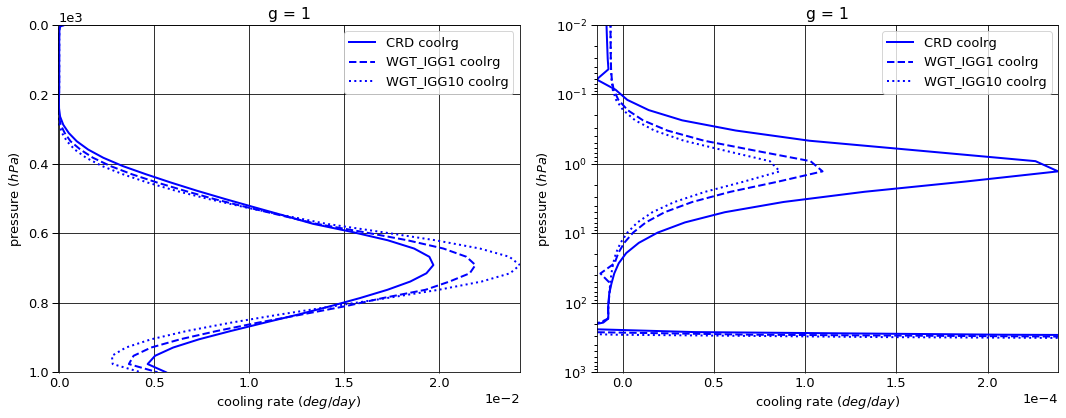

# Figure: cooling rate g-group 2

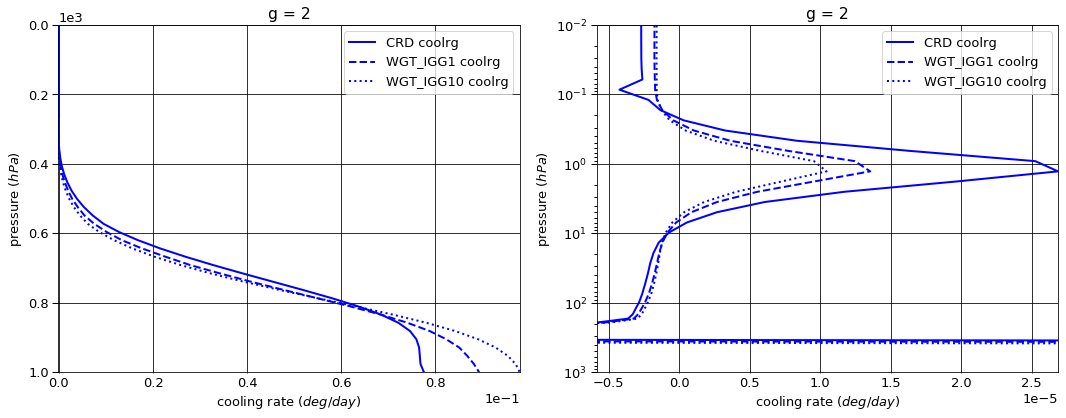

# Figure: cooling rate g-group 3

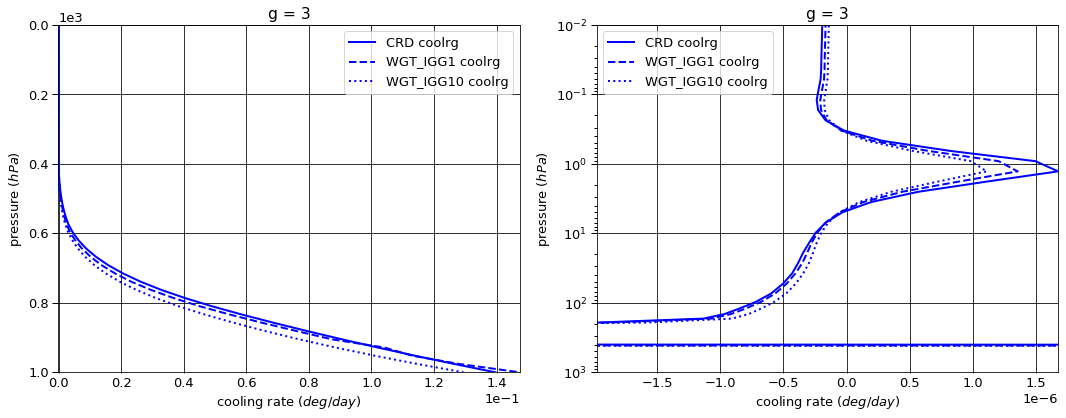

# Figure: cooling rate g-group total

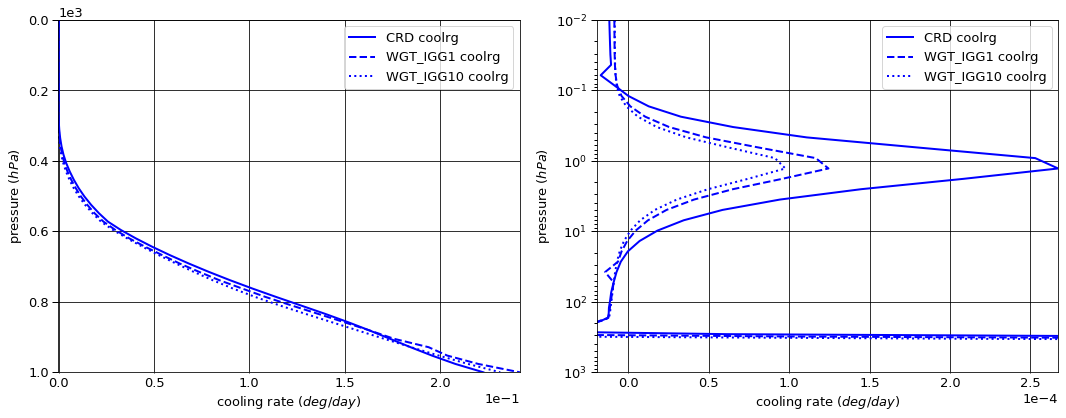

In [18]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [19]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.898779  0.000000  -0.898779
  1013.0   76     -1.258801  1.225695  -0.033106
2 0.0      1      -4.809476  0.000000  -4.809476
  1013.0   76     -5.313345  3.317964  -1.995382
3 0.0      1     -54.783409  0.000000 -54.783409
  1013.0   76    -55.109100  3.153570 -51.955530


WGT_IGG1


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.899783  0.000000  -0.899783
  1013.0   76     -1.258801  1.237699  -0.021102
2 0.0      1      -4.850097  0.000000  -4.850097
  1013.0   76     -5.313345  3.300744  -2.012601
3 0.0      1     -54.805615  0.000000 -54.805615
  1013.0   76    -55.109100  3.050277 -52.058823


WGT_IGG10


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.897797  0.000000  -0.897797
  1013.0   76     -1.258801  1.240926  -0.017875
2 0.0      1      -4.866779  0.000000  -4.866779
  1013.0   76     -5.313345  3.380788  -1.932557
3 0.0      1     -54.850406  0.000000 -54.850406
  1013.0   76    -55.109100  2.644555 -52.464544


WGT_IGG1 - CRD


flug      fldg     fnetg
g pressure level                                  
1 0.0      1     -1.003460e-03  0.000000 -0.001003
  1013.0   76     0.000000e+00  0.012004  0.012004
2 0.0      1     -4.062100e-02  0.000000 -0.040621
  1013.0   76     8.881784e-16 -0.017219 -0.017219
3 0.0      1     -2.220600e-02  0.000000 -0.022206
  1013.0   76     0.000000e+00 -0.103293 -0.103293


WGT_IGG10 - CRD


flug      fldg     fnetg
g pressure level                                  
1 0.0      1      9.825400e-04  0.000000  0.000983
  1013.0   76     0.000000e+00  0.015230  0.015230
2 0.0      1     -5.730300e-02  0.000000 -0.057303
  1013.0   76     8.881784e-16  0.062824  0.062825
3 0.0      1     -6.699700e-02  0.000000 -0.066997
  1013.0   76     0.000000e+00 -0.509015 -0.509014

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1     -9.812835e-06
  1001.112500 75     5.620699e-03
2 0.000312    1     -2.663492e-06
  1001.112500 75     7.756460e-02
3 0.000312    1     -1.746466e-07
  1001.112500 75     1.395848e-01


WGT_IGG1


coolrg
g pressure    layer              
1 0.000312    1     -6.852281e-06
  1001.112500 75     5.171920e-03
2 0.000312    1     -1.710837e-06
  1001.112500 75     8.929407e-02
3 0.000312    1     -1.512067e-07
  1001.112500 75     1.474167e-01


WGT_IGG10


coolrg
g pressure    layer              
1 0.000312    1     -6.604812e-06
  1001.112500 75     4.295950e-03
2 0.000312    1     -1.548619e-06
  1001.112500 75     9.792772e-02
3 0.000312    1     -1.275746e-07
  1001.112500 75     1.293927e-01


WGT_IGG1 - CRD


coolrg
g pressure    layer              
1 0.000312    1      2.960554e-06
  1001.112500 75    -4.487791e-04
2 0.000312    1      9.526547e-07
  1001.112500 75     1.172948e-02
3 0.000312    1      2.343991e-08
  1001.112500 75     7.831900e-03


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1      3.208023e-06
  1001.112500 75    -1.324750e-03
2 0.000312    1      1.114873e-06
  1001.112500 75     2.036313e-02
3 0.000312    1      4.707196e-08
  1001.112500 75    -1.019215e-02

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-60.491664,0.000000,-60.491664
1013.0,76,-61.681246,7.697229,-53.984017



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-60.555494,0.000000,-60.555494
1013.0,76,-61.681246,7.588721,-54.092526



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-60.614981,0.000000,-60.614981
1013.0,76,-61.681246,7.266269,-54.414976



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-0.06383,0.000000,-0.063830
1013.0,76,0.00000,-0.108508,-0.108509



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-0.123317,0.00000,-0.123317
1013.0,76,0.000000,-0.43096,-0.430959


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.000013
1001.112500,75,0.222770



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,-0.000009
1001.112500,75,0.241883



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,-0.000008
1001.112500,75,0.231616



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.000004
1001.112500,75,0.019113



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.000004
1001.112500,75,0.008846


In [20]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.019389,0.020953
2,0.084389,0.087107
3,0.896222,0.891940


In [21]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,1.191856e-23
2,1.000925e-24
3,2.367330e-27


In [22]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [23]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,1.191856e-23,NaN,0.019389,0.020953,0.019389,0.020953,600.0
2,1.000925e-24,0.083980,0.084389,0.087107,0.103778,0.108060,600.0
3,2.367330e-27,0.002365,0.896222,0.891940,1.000000,1.000000,600.0


In [24]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [25]:
absmean_absmeanlog = pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1, 2],
                sep=r'\s+')

taulyr = pd.read_csv(os.path.join(crd.rundir, 'output_taulyr.dat'),
                     index_col=[0, 1, 2],
                     sep=r'\s+')


pd.set_option('display.max_rows', None)
display.display( 
    pd.concat([absmean_absmeanlog, taulyr], axis=1)
    )
pd.reset_option('display.max_rows')



absmean    absmeanlog      ratio        taulyr
layer g pressure                                                        
1     1 0.000312     1.556903e-23  5.362395e-25  29.033718  6.857715e-10
      2 0.000312     4.875319e-25  1.352671e-26  36.042164  2.335370e-11
      3 0.000312     2.203556e-27  2.449314e-29  89.966263  1.598216e-13
2     1 0.000750     1.569115e-23  5.376028e-25  29.187260  2.783376e-10
      2 0.000750     4.905074e-25  1.356659e-26  36.155531  9.463313e-12
      3 0.000750     2.224694e-27  2.463775e-29  90.296132  6.499106e-14
3     1 0.001052     1.595353e-23  5.403197e-25  29.526099  3.967128e-10
      2 0.001052     4.969276e-25  1.364678e-26  36.413535  1.344281e-11
      3 0.001052     2.270231e-27  2.488486e-29  91.229405  9.300629e-14
4     1 0.001476     1.623591e-23  5.432164e-25  29.888477  5.661711e-10
      2 0.001476     5.038592e-25  1.373189e-26  36.692635  1.911867e-11
      3 0.001476     2.319524e-27  2.515995e-29  92.191127  1.333082e-13
5     1 0.002070     1.652336e-23  5.461557e-25  30.253939  8.078474e-10
      2 0.002070     5.109384e-25  1.381787e-26  36.976637  2.718781e-11
      3 0.002070     2.370013e-27  2.545614e-29  93.101803  1.910425e-13
6     1 0.002904     1.681569e-23  5.491579e-25  30.620865  1.152804e-09
      2 0.002904     5.181610e-25  1.390531e-26  37.263524  3.867002e-11
      3 0.002904     2.421684e-27  2.578152e-29  93.931000  2.738206e-13
7     1 0.004074     1.711296e-23  5.522562e-25  30.987351  1.645095e-09
      2 0.004074     5.255286e-25  1.399517e-26  37.550713  5.500754e-11
      3 0.004074     2.474575e-27  2.614799e-29  94.637291  3.924919e-13
8     1 0.005714     1.741522e-23  5.554976e-25  31.350668  2.347449e-09
      2 0.005714     5.330420e-25  1.408878e-26  37.834501  7.824858e-11
      3 0.005714     2.528726e-27  2.657242e-29  95.163564  5.625823e-13
9     1 0.008015     1.772259e-23  5.589489e-25  31.706998  3.349754e-09
      2 0.008015     5.407023e-25  1.418807e-26  38.109653  1.113208e-10
      3 0.008015     2.584194e-27  2.707875e-29  95.432559  8.064483e-13
10    1 0.011243     1.803505e-23  5.627028e-25  32.050757  4.779954e-09
      2 0.011243     5.485061e-25  1.429571e-26  38.368587  1.583803e-10
      3 0.011243     2.641024e-27  2.770071e-29  95.341403  1.156079e-12
11    1 0.015771     1.835257e-23  5.668904e-25  32.374103  6.820905e-09
      2 0.015771     5.564475e-25  1.441550e-26  38.600646  2.253509e-10
      3 0.015771     2.699271e-27  2.848583e-29  94.758378  1.657436e-12
12    1 0.022122     1.867526e-23  5.716976e-25  32.666327  9.733363e-09
      2 0.022122     5.645217e-25  1.455284e-26  38.791183  3.206557e-10
      3 0.022122     2.759036e-27  2.950098e-29  93.523550  2.376434e-12
13    1 0.031031     1.900329e-23  5.773856e-25  32.912650  1.388984e-08
      2 0.031031     5.727209e-25  1.471532e-26  38.920047  4.562895e-10
      3 0.031031     2.820457e-27  3.083954e-29  91.455880  3.407809e-12
14    1 0.043528     1.935847e-23  5.844980e-25  33.119829  1.984388e-08
      2 0.043528     5.815881e-25  1.491875e-26  38.983707  6.499283e-10
      3 0.043528     2.887746e-27  3.265196e-29  88.440203  4.894521e-12
15    1 0.061057     2.044279e-23  5.992306e-25  34.115064  2.936936e-08
      2 0.061057     6.093366e-25  1.534350e-26  39.713024  9.548026e-10
      3 0.061057     3.093832e-27  3.585299e-29  86.292159  7.355970e-12
16    1 0.085645     2.363856e-23  6.317852e-25  37.415496  4.751696e-08
      2 0.085645     6.942303e-25  1.630628e-26  42.574398  1.523828e-09
      3 0.085645     3.722861e-27  4.246234e-29  87.674425  1.241572e-11
17    1 0.120136     2.898381e-23  6.791530e-25  42.676402  8.146208e-08
      2 0.120136     8.452627e-25  1.783134e-26  47.403203  2.597511e-09
      3 0.120136     4.855629e-27  5.374807e-29  90.340534  2.271344e-11
18    1 0.168516     3.564091e-23  7.356212e-25  48.450083  1.401309e-07
      2 0.168516     1.048824e-24  1.987864e-26  52.761353  4.513266e-09
      3 0.1

# Histogram of wavenumbers in g-group 1

In [26]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
